In [1]:
#!pip install torchsummary
#!pip install opencv-python
# !pip install torchvision

In [2]:
# check for GPU
!nvidia-smi

Wed Oct  9 11:17:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.78                 Driver Version: 560.78         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:31:00.0 Off |                  N/A |
| N/A   41C    P8              1W /   98W |     157MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# load the data
# %conda install pytorch torchvision torchaudio cpuonly -c pytorch
import os
# avoid kernel crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
transform = transforms.Compose([
    transforms.ToTensor(),
])
class CellDataset(Dataset):
    def __init__(self, root, transform, img_size):
        self.path = root
        self.transform = transform
        self.img_size = img_size
        self.files = os.listdir(self.path + "/images")
    def __getitem__(self, index):
        fn = self.files[index]
        img = Image.open(self.path + "/images/" + fn).resize(self.img_size)
        mask = Image.open(self.path + "/masks/" + fn).resize(self.img_size)
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return (img, mask)
    def __len__(self):
        return len(self.files)

In [4]:
train_path = r"./kmms_training"
test_path = r"./kmms_test"
img_size = (512, 512)

train_dataset = CellDataset(train_path, transform, img_size)
test_dataset = CellDataset(test_path, transform, img_size)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [5]:
# display one item
import numpy as np
import matplotlib.pyplot as mp

img, mask = train_dataset.__getitem__(0)
img, mask = img.mul(255).byte(), mask.mul(255).byte()
# transpose the channel position for displaying
img, mask = img.numpy().transpose((1, 2, 0)), mask.numpy().transpose((1, 2, 0))
print("img shape = {}, mask shape = {}".format(img.shape, mask.shape))


img shape = (512, 512, 3), mask shape = (512, 512, 1)


Text(0.5, 1.0, 'mixed')

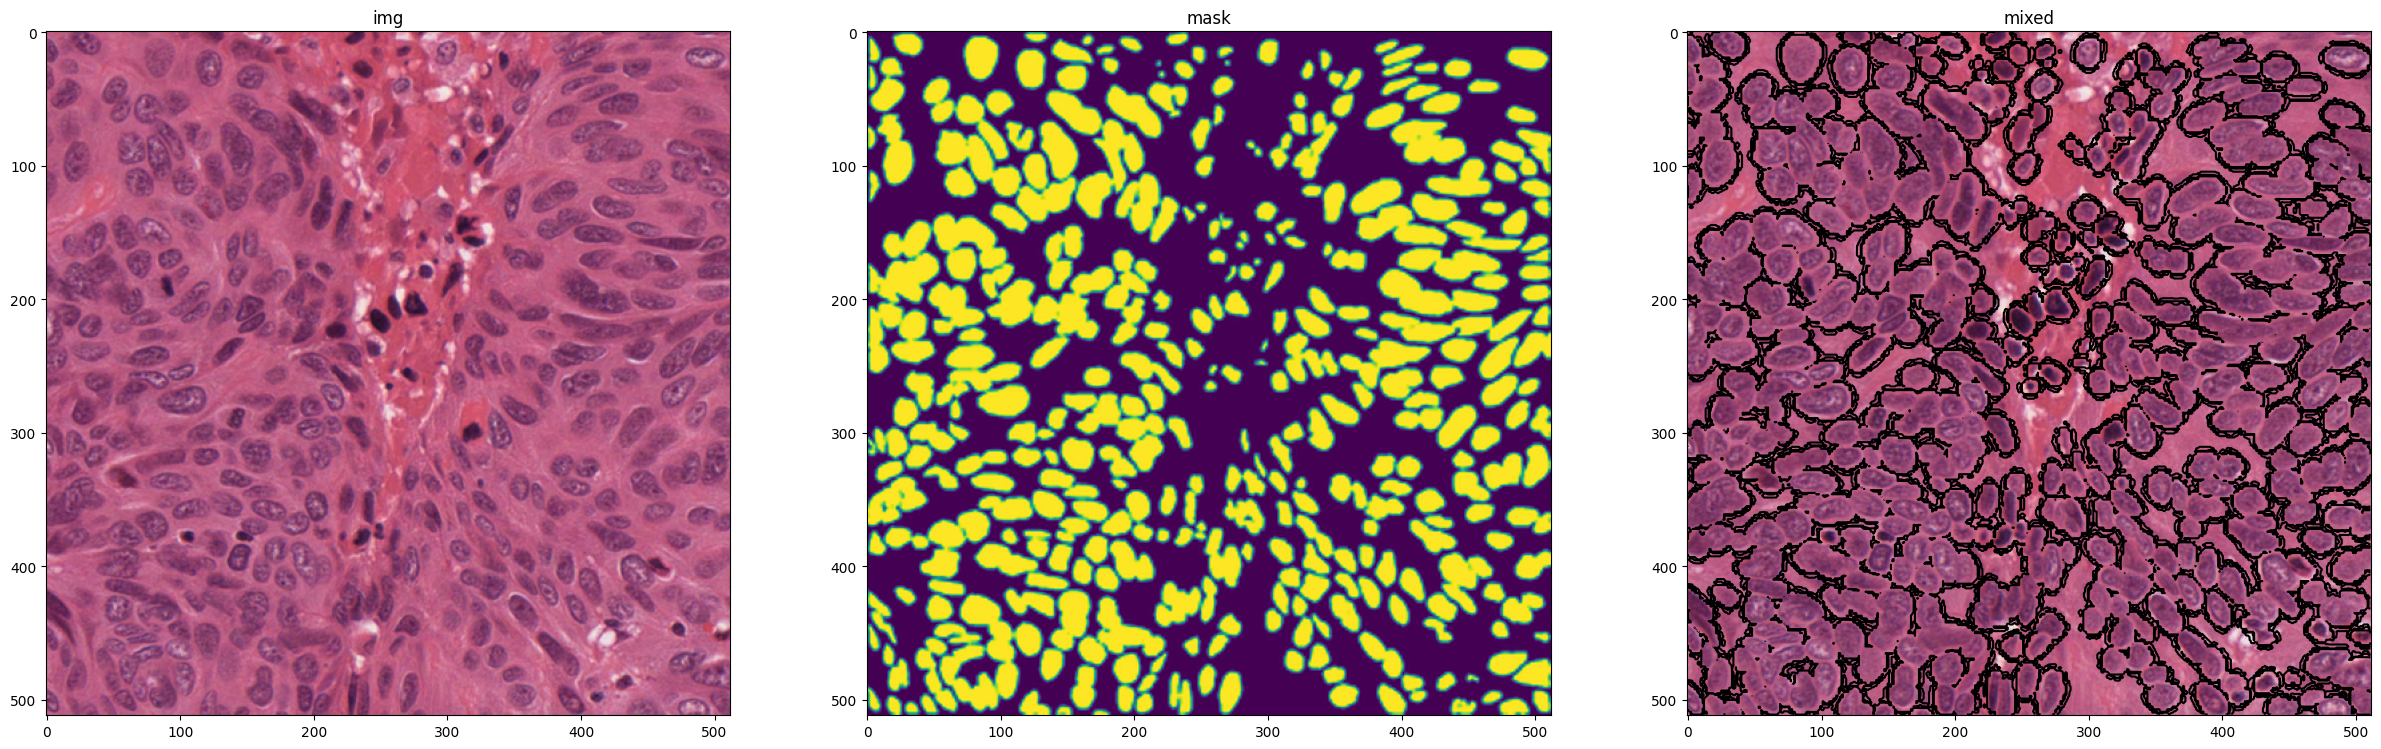

In [6]:
fig, ax = mp.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(img)
ax[0].set_title("img")
ax[1].imshow(mask.squeeze())
ax[1].set_title("mask")
ax[2].imshow(img)
ax[2].contour(mask.squeeze(), colors="k", levels=[0.5])
ax[2].set_title("mixed")

In [7]:
# constructing the Unet
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        output1 = self.conv(x)
        return output1

# upper sampling
class Up_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    def forward(self, input1, input2):
        up2 = self.up(input2)
        # calculate the padding size by the transposed convolution size
        padding = (up2.size()[-1] - input1.size()[-1]) // 2
        output1 = F.pad(input1, 2 *[padding, padding])
        outputs = torch.cat([up2, output1], 1)
        return self.conv(outputs)
    
class Unet(nn.Module):
    def __init__(self, in_channel=3):
        super().__init__()
        # feature scaling
        self.in_channel = in_channel
        self.filters = [16, 32, 64, 128, 256]

        # down sampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = DoubleConv(self.in_channel, self.filters[0])
        self.conv2 = DoubleConv(self.filters[0], self.filters[1])
        self.conv3 = DoubleConv(self.filters[1], self.filters[2])
        self.conv4 = DoubleConv(self.filters[2], self.filters[3])

        # U-center
        self.center = DoubleConv(self.filters[3], self.filters[4])

        # up sampling
        self.up4 = Up_block(self.filters[4], self.filters[3])
        self.up3 = Up_block(self.filters[3], self.filters[2])
        self.up2 = Up_block(self.filters[2], self.filters[1])
        self.up1 = Up_block(self.filters[1], self.filters[0])

        # full connection
        # one channel black and white out
        self.final = nn.Conv2d(self.filters[0], 1, kernel_size=1)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        # down sampling
        c1 = self.conv1(x)
        p1 = self.pool(c1)
        c2 = self.conv2(p1)
        p2 = self.pool(c2)
        c3 = self.conv3(p2)
        p3 = self.pool(c3)
        c4 = self.conv4(p3)
        p4 = self.pool(c4)

        # U-center
        c5 = self.center(p4)

        # up sampling
        u4 = self.up4(c4, c5)
        u3 = self.up3(c3, u4)
        u2 = self.up2(c2, u3)
        u1 = self.up1(c1, u2)

        # full connection
        # one channel black and white out
        out = self.final(u1)
        out = self.sig(out)
        return out

In [8]:
from torchsummary import summary
device = torch.cuda.device('cuda')
model = Unet()
model = model.cuda()
print(summary(model, (3, 512, 512)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             432
       BatchNorm2d-2         [-1, 16, 512, 512]              32
              ReLU-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]           2,304
       BatchNorm2d-5         [-1, 16, 512, 512]              32
              ReLU-6         [-1, 16, 512, 512]               0
        DoubleConv-7         [-1, 16, 512, 512]               0
         MaxPool2d-8         [-1, 16, 256, 256]               0
            Conv2d-9         [-1, 32, 256, 256]           4,608
      BatchNorm2d-10         [-1, 32, 256, 256]              64
             ReLU-11         [-1, 32, 256, 256]               0
           Conv2d-12         [-1, 32, 256, 256]           9,216
      BatchNorm2d-13         [-1, 32, 256, 256]              64
             ReLU-14         [-1, 32, 2

In [15]:
'''
cuda avaliability has already been checked
'''
# train process
from torch import optim
# for lr optimization
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time
train_loss = []
def train_process(model, train_loader, test_dataset, train_loss:list, num_epoch=100):
    t0 = time.time()
    loss_function = nn.BCEWithLogitsLoss().cuda()
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
    exp_lr_scheuler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    model.train(True)   

    for i in range(num_epoch):
        running_loss = 0.0
        for inputs, labels in train_loader:
            train_input, train_label = Variable(inputs.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            out = model(train_input)
            loss = loss_function(out.squeeze(1), train_label.squeeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / test_dataset.__len__()
        print('epoch:{}, Loss:{:.4f}'.format(i+1, epoch_loss))
        # write down the training process
        with open('./train_process/log.txt', 'a+') as f:
            f.write('{}-{}\n'.format(i+1, epoch_loss))
        exp_lr_scheuler.step()
        train_loss.append(epoch_loss)
    t1 = time.time()
    print("training time = {:.2f} minutes".format((t1-t0)/60))

'''
judging by the loss curve, the best epoch num should be around 20-30, which
is fairly small for most deep learning models.
'''
# train_process(model, train_loader, test_dataset, train_loss)

epoch:1, Loss:0.2824
epoch:2, Loss:0.2814
epoch:3, Loss:0.2811
epoch:4, Loss:0.2811
epoch:5, Loss:0.2807
epoch:6, Loss:0.2805
epoch:7, Loss:0.2798
epoch:8, Loss:0.2797
epoch:9, Loss:0.2798
epoch:10, Loss:0.2795
epoch:11, Loss:0.2791
epoch:12, Loss:0.2793
epoch:13, Loss:0.2793
epoch:14, Loss:0.2787
epoch:15, Loss:0.2791
epoch:16, Loss:0.2785
epoch:17, Loss:0.2788
epoch:18, Loss:0.2794
epoch:19, Loss:0.2791
epoch:20, Loss:0.2794
epoch:21, Loss:0.2786
epoch:22, Loss:0.2786
epoch:23, Loss:0.2787
epoch:24, Loss:0.2780
epoch:25, Loss:0.2789
epoch:26, Loss:0.2786
epoch:27, Loss:0.2787
epoch:28, Loss:0.2788
epoch:29, Loss:0.2788
epoch:30, Loss:0.2789
epoch:31, Loss:0.2790
epoch:32, Loss:0.2789
epoch:33, Loss:0.2787
epoch:34, Loss:0.2790
epoch:35, Loss:0.2787
epoch:36, Loss:0.2788
epoch:37, Loss:0.2788
epoch:38, Loss:0.2787
epoch:39, Loss:0.2784
epoch:40, Loss:0.2786
epoch:41, Loss:0.2790
epoch:42, Loss:0.2786
epoch:43, Loss:0.2782
epoch:44, Loss:0.2784
epoch:45, Loss:0.2786
epoch:46, Loss:0.27

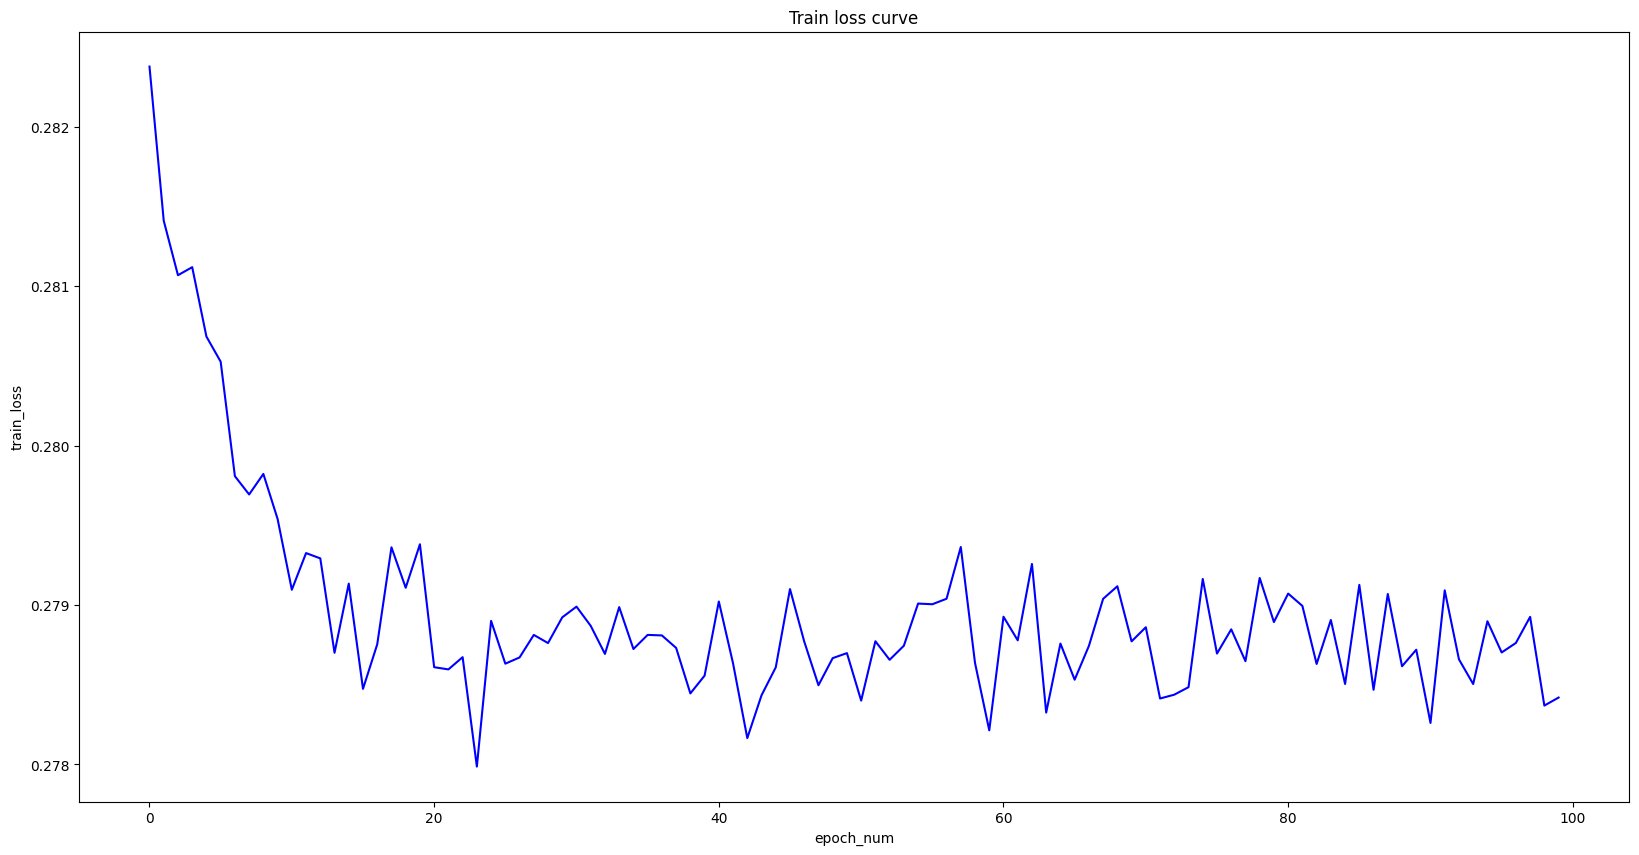

In [18]:
# training curve
mp.figure(figsize=(20, 10))
mp.plot(train_loss, 'b', label='loss')
mp.title('Train loss curve')
mp.xlabel('epoch_num')
mp.ylabel('train_loss')
mp.savefig('./train_process/loss.png', format='png', dpi=200)

# save the model
torch.save(model.state_dict(), './train_process/model.pkl')



In [1]:
# model evaluation
import cv2
model.load_state_dict(torch.load('./train_process/model.pkl'))
model.eval()
model.to("cpu")
with torch.no_grad():
    for inputs, labels in test_loader:
        out = model(inputs)
        out = out.mul(255).byte().squeeze().numpy()
        labels = labels.mul(255).byte().squeeze().numpy()

NameError: name 'model' is not defined